# Setup

In [1]:
!pip install --quiet kaggle mido

  DEPRECATION: kaggle is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import mido
import os

import matplotlib.pyplot as plt
import string
import numpy as np

# Datasets

In [5]:
# Pop Music
!kaggle datasets download kritanjalijain/music-midi-dataset
!mkdir -p pop_music
!unzip music-midi-dataset.zip -d pop_music


Dataset URL: https://www.kaggle.com/datasets/kritanjalijain/music-midi-dataset
License(s): CC-BY-SA-4.0
  0%|                                               | 0.00/55.5k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 55.5k/55.5k [00:00<00:00, 12.9MB/s]
Archive:  music-midi-dataset.zip
  inflating: pop_music/midi_dataset/midi_dataset/x (1).mid  
  inflating: pop_music/midi_dataset/midi_dataset/x (10).mid  
  inflating: pop_music/midi_dataset/midi_dataset/x (11).mid  
  inflating: pop_music/midi_dataset/midi_dataset/x (12).mid  
  inflating: pop_music/midi_dataset/midi_dataset/x (13).mid  
  inflating: pop_music/midi_dataset/midi_dataset/x (14).mid  
  inflating: pop_music/midi_dataset/midi_dataset/x (15).mid  
  inflating: pop_music/midi_dataset/midi_dataset/x (16).mid  
  inflating: pop_music/midi_dataset/midi_dataset/x (17).mid  
  inflating: pop_music/midi_dataset/midi_dataset/x (18).mid  
  inflating: pop_music/midi_dataset/midi_dataset/x (19).mid  
  inflating: pop_mus

In [6]:
# Classical Music
!kaggle datasets download soumikrakshit/classical-music-midi
!mkdir -p classical_music
!unzip classical-music-midi.zip -d classical_music

Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/classical-music-midi
License(s): unknown
100%|██████████████████████████████████████| 2.33M/2.33M [00:00<00:00, 4.19MB/s]
100%|██████████████████████████████████████| 2.33M/2.33M [00:00<00:00, 3.62MB/s]
Archive:  classical-music-midi.zip
  inflating: classical_music/albeniz/alb_esp1.mid  
  inflating: classical_music/albeniz/alb_esp2.mid  
  inflating: classical_music/albeniz/alb_esp3.mid  
  inflating: classical_music/albeniz/alb_esp4.mid  
  inflating: classical_music/albeniz/alb_esp5.mid  
  inflating: classical_music/albeniz/alb_esp6.mid  
  inflating: classical_music/albeniz/alb_se1.mid  
  inflating: classical_music/albeniz/alb_se2.mid  
  inflating: classical_music/albeniz/alb_se3.mid  
  inflating: classical_music/albeniz/alb_se4.mid  
  inflating: classical_music/albeniz/alb_se5.mid  
  inflating: classical_music/albeniz/alb_se6.mid  
  inflating: classical_music/albeniz/alb_se7.mid  
  inflating: classical_music/alben

## Trying MusicNet
* [MusicNet - Kaggle](https://www.kaggle.com/datasets/imsparsh/musicnet-dataset/data)

In [1]:
#!/bin/bash
!kaggle datasets download imsparsh/musicnet-dataset

Dataset URL: https://www.kaggle.com/datasets/imsparsh/musicnet-dataset
License(s): CC0-1.0
  0%|                                      | 42.0M/21.5G [00:04<31:39, 12.1MB/s]^C
  0%|                                      | 43.0M/21.5G [00:04<40:31, 9.48MB/s]
User cancelled operation


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imsparsh/musicnet-dataset")

print("Path to dataset files:", path)

  0%|▏                                                                                                                          | 27.0M/21.5G [00:02<38:10, 10.1MB/s]


KeyboardInterrupt: 

# Workspace

In [5]:
classical_music_list = os.listdir('classical_music')
pop_music_list = os.listdir('pop_music')

In [12]:
classical_music_list = [f"classical_music/{p}" for p in classical_music_list]
pop_music_list = [f"pop_music/{p}" for p in pop_music_list]

In [13]:
first_classical_midi = classical_music_list[0]
midi_file = mido.MidiFile(first_classical_midi)
print("MIDI File Type:", midi_file.type)
print("Number of Tracks:", len(midi_file.tracks))
print("Ticks per Beat:", midi_file.ticks_per_beat)

MIDI File Type: 1
Number of Tracks: 17
Ticks per Beat: 480


# midi to numpy array
* https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c

In [21]:
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [22]:
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

In [23]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [24]:
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

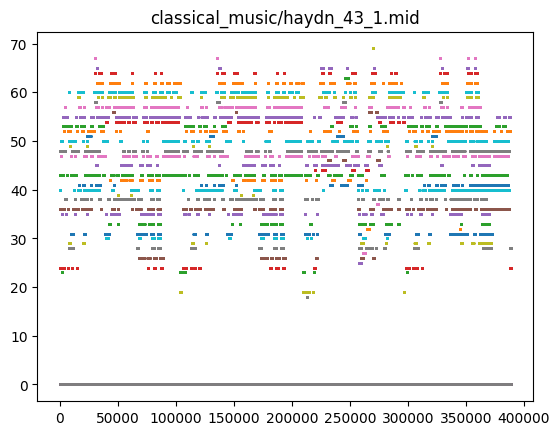

CPU times: user 16.3 s, sys: 1.84 s, total: 18.2 s
Wall time: 18.8 s


In [33]:
%%time
result_array = mid2arry(midi_file)
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title(first_classical_midi)
plt.show()

In [34]:
result_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Converting all midi files to numpy arrays

In [3]:
classical_music_list = [f"classical_music/{p}" for p in os.listdir('classical_music') if p.endswith(('.mid', '.midi'))]
pop_music_list = [f"pop_music/{p}" for p in os.listdir('pop_music') if p.endswith(('.mid', '.midi'))]

In [4]:
arrays_folder_path = 'numpy_arrays'
if not os.path.exists(arrays_folder_path):
    os.mkdir(arrays_folder_path)

In [5]:
classical_music_dict = [{p: mido.MidiFile(p) for p in classical_music_list}]
pop_music_dict = [{p: mido.MidiFile(p) for p in pop_music_list}]

In [ ]:
classical_music_dict[0]